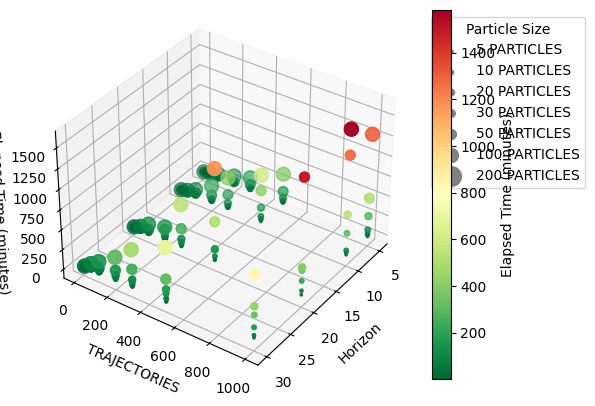

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import Normalize

# Read data from CSV files
job_info_df = pd.read_csv('https://raw.githubusercontent.com/bboyfury/pomcppf_experiment_1/main/job_info_output.csv')
sacct_df = pd.read_csv('https://raw.githubusercontent.com/bboyfury/pomcppf_experiment_1/main/job_statistics_output.csv')

# Ensure JobID columns are strings
job_info_df['JobID'] = job_info_df['JobID'].astype(str)
sacct_df['JobID'] = sacct_df['JobID'].astype(str)

# Extract the main JobID (before any dots or underscores)
sacct_df['MainJobID'] = sacct_df['JobID'].str.split(r'[._]').str[0]
job_info_df['MainJobID'] = job_info_df['JobID'].str.split(r'[._]').str[0]

# Merge the two dataframes on 'MainJobID'
merged_df = pd.merge(job_info_df, sacct_df, on='MainJobID')

# Function to convert MaxRSS to bytes
def parse_maxrss(value):
    if isinstance(value, str) and value.endswith('K'):
        return float(value[:-1]) * 1024
    elif isinstance(value, str) and value.endswith('M'):
        return float(value[:-1]) * 1024 * 1024
    elif isinstance(value, str) and value.endswith('G'):
        return float(value[:-1]) * 1024 * 1024 * 1024
    else:
        return float(value)

# Convert necessary columns to numeric types
numeric_columns = ['TRAJECTORIES', 'Horizon', 'PARTICLES', 'ElapsedRaw']
for col in numeric_columns:
    merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')



merged_df['ElapsedRaw'] = merged_df['ElapsedRaw'] / 60  # Convert seconds to minutes

# Drop rows with missing values in key columns
merged_df.dropna(subset=['TRAJECTORIES', 'Horizon', 'ElapsedRaw', 'PARTICLES'], inplace=True)

# Normalize MaxRSS_MB for color mapping

# Scale PARTICLES for marker size (adjust scaling factor for visual clarity)
particle_sizes = merged_df['PARTICLES'] / merged_df['PARTICLES'].max() * 100  # Scaling particle size

# Now, we create the 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

norm = Normalize(vmin=merged_df['ElapsedRaw'].min(), vmax=merged_df['ElapsedRaw'].max())


sc = ax.scatter(merged_df['Horizon'], merged_df['TRAJECTORIES'], merged_df['ElapsedRaw'], 
                c=merged_df['ElapsedRaw'], cmap='RdYlGn_r', norm=norm, s=particle_sizes, marker='o')

# Add a color bar for Elapsed Time (seconds)
plt.colorbar(sc, ax=ax, label='Elapsed Time (minutes)')
# Set labels
ax.set_xlabel('Horizon')
ax.set_ylabel('TRAJECTORIES')
ax.set_zlabel('Elapsed Time (minutes)')

# Add a legend for particle size
# Creating a few dummy points with varying sizes for the legend
for particle_count, size in zip([5, 10, 20, 30, 50, 100, 200], [5, 10, 20, 30, 50, 100, 200]):
    ax.scatter([], [], [], s=size, c='gray', label=f'{particle_count} PARTICLES')

# Add the legend for particle sizes
ax.legend(loc='upper right', title='Particle Size', bbox_to_anchor=(1.5, 1), prop={'size': 10})
# Customize the view angle
ax.view_init(elev=35., azim=35)

# Show the plot
plt.show()
